In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract #tesseractOCR
!pip install opencv-python

**Mounted Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**TesseractOCR**

In [54]:
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
import cv2
import glob
import os
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files

from PIL import Image

**HelperFunction**

In [34]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def remove_noise(image):
    return cv2.medianBlur(image,5)

def denoise(image):
    return cv2.GaussianBlur(image,(5,5),0)

def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
       angle = -(90 + angle)
    else:
       angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def canny(image):
    return cv2.Canny(image, 100, 200)

def upsize(image):
    return cv2.resize(image,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)

In [48]:
def show_result(image,choice = 1):
    if choice == 1:
       image = upsize(image)
    gray = get_grayscale(image)
    gray = denoise(gray)
    thresh = thresholding(gray)
    open_util = opening(gray)
    canny_util = canny(gray)

    images = [gray,thresh,open_util,canny_util]
    results = []
    for img in images:
        predicted_result = pytesseract.image_to_string(img, lang ='eng',config=custom_config)
        results.append(predicted_result)
    for img,res in zip(images,results):
        cv2_imshow(img)    

In [59]:
config ='--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
custom_config = r'--oem 3 --psm 6'
black_config = r'-c tessedit_char_blacklist=0123456789 --psm 6'

I98A-016.57



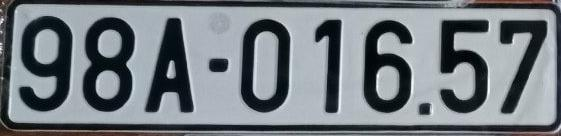

In [6]:
#not preprocessing

path_to_image = "/content/drive/MyDrive/DATA/New_data/Full biển/1.jpg"
img = cv2.imread(path_to_image)
predicted_result = pytesseract.image_to_string(img, lang ='eng',config=config)
print(predicted_result)
cv2_imshow(img)

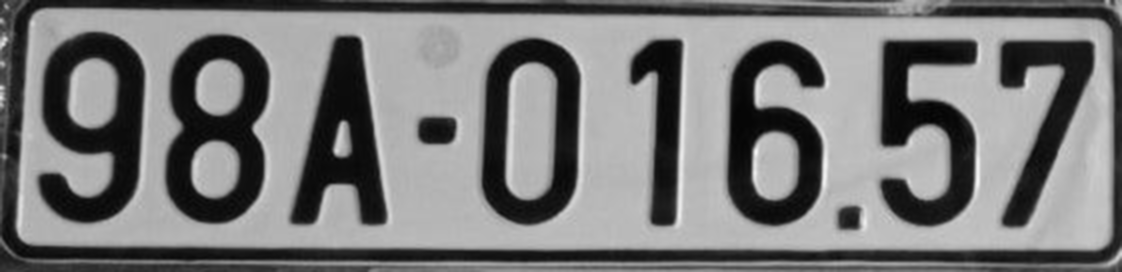

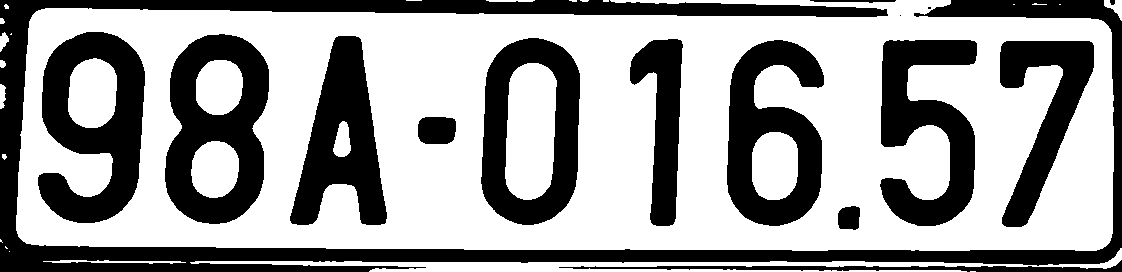

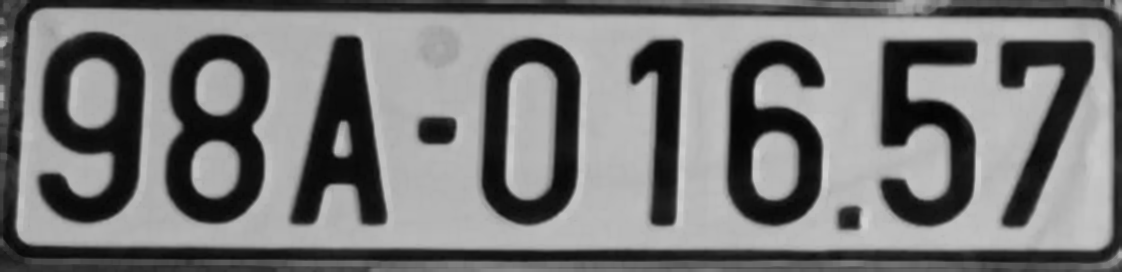

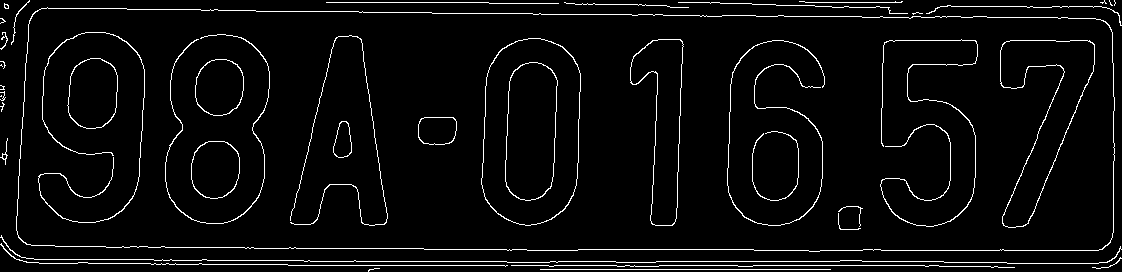

In [49]:
#preprocessing
show_result(img)

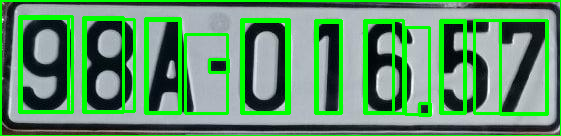

-1

In [52]:
#get bounding box
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

cv2_imshow(img)
cv2.waitKey(0)

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


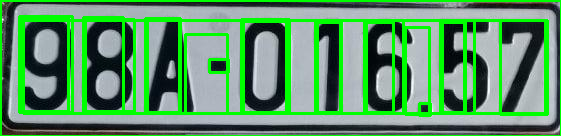

In [58]:
##confidence with bounding box
d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img)